<a href="https://colab.research.google.com/github/mattswalter/Word2vec_Park_Recommendations/blob/main/word2vec_park_recommendations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Author: Mswalter@udel.edu

Interpreted from: https://www.kdnuggets.com/2020/08/content-based-recommendation-system-word-embeddings.html

Description: Use Word2vec from gensim to create word embeddings for all of the user reviews for parks in Philadelphia left on Google Maps. Use those reviews associated with each park to recommend the most similar parks based on their user reviews calculated as cosine similarity.

In [ ]:
from sklearn.manifold import TSNE
import pandas as pd
import numpy as np
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from sklearn.metrics.pairwise import linear_kernel
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize import RegexpTokenizer
import re
import string
import random
from io import BytesIO
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics.pairwise import cosine_similarity
from gensim.models import Word2Vec
from gensim.models.phrases import Phrases, Phraser
from matplotlib import pyplot
from gensim.models import KeyedVectors
import warnings
from sklearn.decomposition import PCA
import gensim
import matplotlib.cm as cm


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Import and clean data

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/parks_reviews_philly.csv')

In [ ]:
df.head()

,url,place_name,place_score,num_reviews,user_number_reviews,user_number_photos,time,score,text
0,https://www.google.com/maps/place/20th+%26+Tio...,20th & Tioga Street Park,4.2,43,63.0,NaN,3 months ago,5,Beautiful community garden space in the neighb...
1,https://www.google.com/maps/place/20th+%26+Tio...,20th & Tioga Street Park,4.2,43,24.0,NaN,3 months ago,4,Great job of revitalizing this ball park... So...
2,https://www.google.com/maps/place/20th+%26+Tio...,20th & Tioga Street Park,4.2,43,91.0,NaN,2 years ago,5,This is my childhood playground. I love my ne...
3,https://www.google.com/maps/place/20th+%26+Tio...,20th & Tioga Street Park,4.2,43,NaN,NaN,11 months ago,5,Beauty in the midst of chaos. True blessing to...
4,https://www.google.com/maps/place/20th+%26+Tio...,20th & Tioga Street Park,4.2,43,NaN,NaN,a year ago,5,It is a beautiful place to pause and gather yo...


In [ ]:
df.dropna(subset=['text'], inplace=True)

In [ ]:
df = df[['place_name', 'place_score', 'score', 'text', 'url', 'num_reviews']]
df.head()

,place_name,place_score,score,text,url,num_reviews
0,20th & Tioga Street Park,4.2,5,Beautiful community garden space in the neighb...,https://www.google.com/maps/place/20th+%26+Tio...,43
1,20th & Tioga Street Park,4.2,4,Great job of revitalizing this ball park... So...,https://www.google.com/maps/place/20th+%26+Tio...,43
2,20th & Tioga Street Park,4.2,5,This is my childhood playground. I love my ne...,https://www.google.com/maps/place/20th+%26+Tio...,43
3,20th & Tioga Street Park,4.2,5,Beauty in the midst of chaos. True blessing to...,https://www.google.com/maps/place/20th+%26+Tio...,43
4,20th & Tioga Street Park,4.2,5,It is a beautiful place to pause and gather yo...,https://www.google.com/maps/place/20th+%26+Tio...,43


In [ ]:
df1 = df

In [ ]:
df1['text'] = df1[['place_name','text']].groupby(['place_name'])['text'].transform(lambda x: ','.join(x))
df1 = df1[['place_name', 'text']].drop_duplicates()
df1

,place_name,text
0,20th & Tioga Street Park,Beautiful community garden space in the neighb...
43,29th & Chalmers Playground,Pretty decent place to relax or enjoy the acti...
290,33rd and Wallace Playground,Nice place to go to. Playground is awesome and...
291,48th & Woodland Playground,Great game for the kids in Phillies RBI BASEBA...
409,8th & Diamond Playground,Sunday afternoon it was nice. Kids teens famil...
...,...,...
83682,Wissahickon Valley Park,People who live in and around Philadelphia are...
88582,Wissinoming Park,Such a great park that has been part of Philad...
89380,Wister Playground,"First time here, my boys definitely enjoyed it..."
89455,Woodside Park,"Great family park, fun in summer and winter! N..."


Clean review text of stop words, uppercase letters, and symbols.

In [ ]:
def _removeNonAscii(s):
    return "".join(i for i in s if  ord(i)<128)

def make_lower_case(text):
    return text.lower()

def remove_stop_words(text):
    text = text.split()
    stops = set(stopwords.words("english"))
    text = [w for w in text if not w in stops]
    text = " ".join(text)
    return text
    
def remove_punctuation(text):
    tokenizer = RegexpTokenizer(r'\w+')
    text = tokenizer.tokenize(text)
    text = " ".join(text)
    return text

df1['cleaned'] = df1['text'].apply(_removeNonAscii)
df1['cleaned'] = df1.cleaned.apply(func = make_lower_case)
df1['cleaned'] = df1.cleaned.apply(func = remove_stop_words)
df1['cleaned'] = df1.cleaned.apply(func=remove_punctuation)


In [ ]:
df1

,place_name,text,cleaned
0,20th & Tioga Street Park,Beautiful community garden space in the neighb...,beautiful community garden space neighborhood ...
43,29th & Chalmers Playground,Pretty decent place to relax or enjoy the acti...,pretty decent place relax enjoy activities goi...
290,33rd and Wallace Playground,Nice place to go to. Playground is awesome and...,nice place go to playground awesome clean even...
291,48th & Woodland Playground,Great game for the kids in Phillies RBI BASEBA...,great game kids phillies rbi baseball i attend...
409,8th & Diamond Playground,Sunday afternoon it was nice. Kids teens famil...,sunday afternoon nice kids teens families it s...
...,...,...,...
83682,Wissahickon Valley Park,People who live in and around Philadelphia are...,people live around philadelphia truly blessed ...
88582,Wissinoming Park,Such a great park that has been part of Philad...,great park part philadelphias history since 19...
89380,Wister Playground,"First time here, my boys definitely enjoyed it...",first time here boys definitely enjoyed it wen...
89455,Woodside Park,"Great family park, fun in summer and winter! N...",great family park fun summer winter nice clean...


Create a corpus or list of each word included in user reviews

In [ ]:
corpus = []
for words in df1['cleaned']:
    corpus.append(words.split())

Train model on the Google News dataset

In [ ]:
# Downloading the Google pretrained Word2Vec Model
!wget -P /root/input/ -c "https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz"

EMBEDDING_FILE = '/root/input/GoogleNews-vectors-negative300.bin.gz'
google_word2vec = KeyedVectors.load_word2vec_format(EMBEDDING_FILE, binary=True)

# Training our corpus with Google Pretrained Model

google_model = Word2Vec(size = 300, window=5, min_count = 2, workers = -1)
google_model.build_vocab(corpus)

#model.intersect_word2vec_format('./word2vec/GoogleNews-vectors-negative300.bin', lockf=1.0, binary=True)

google_model.intersect_word2vec_format(EMBEDDING_FILE, lockf=1.0, binary=True)

google_model.train(corpus, total_examples=google_model.corpus_count, epochs = 5)

--2021-08-27 18:48:50--  https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.140.160
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.140.160|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1647046227 (1.5G) [application/x-gzip]
Saving to: ‘/root/input/GoogleNews-vectors-negative300.bin.gz’

GoogleNews-vectors- 100%[===================>]   1.53G  35.1MB/s    in 52s     

2021-08-27 18:49:42 (30.0 MB/s) - ‘/root/input/GoogleNews-vectors-negative300.bin.gz’ saved [1647046227/1647046227]



(0, 0)

Create vectors

In [ ]:
def vectors(x):
    
    # Creating a list for storing the vectors (description into vectors)
    global word_embeddings
    word_embeddings = []

    # Reading each book description 
    for line in df1['cleaned']:
        avgword2vec = None
        count = 0
        for word in line.split():
            if word in google_model.wv.vocab:
                count += 1
                if avgword2vec is None:
                    avgword2vec = google_model[word]
                else:
                    avgword2vec = avgword2vec + google_model[word]
                
        if avgword2vec is not None:
            avgword2vec = avgword2vec / count
        
            word_embeddings.append(avgword2vec)

In [ ]:
df1 = df1.reset_index(drop=True)
df1

,place_name,text,cleaned
0,20th & Tioga Street Park,Beautiful community garden space in the neighb...,beautiful community garden space neighborhood ...
1,29th & Chalmers Playground,Pretty decent place to relax or enjoy the acti...,pretty decent place relax enjoy activities goi...
2,33rd and Wallace Playground,Nice place to go to. Playground is awesome and...,nice place go to playground awesome clean even...
3,48th & Woodland Playground,Great game for the kids in Phillies RBI BASEBA...,great game kids phillies rbi baseball i attend...
4,8th & Diamond Playground,Sunday afternoon it was nice. Kids teens famil...,sunday afternoon nice kids teens families it s...
...,...,...,...
233,Wissahickon Valley Park,People who live in and around Philadelphia are...,people live around philadelphia truly blessed ...
234,Wissinoming Park,Such a great park that has been part of Philad...,great park part philadelphias history since 19...
235,Wister Playground,"First time here, my boys definitely enjoyed it...",first time here boys definitely enjoyed it wen...
236,Woodside Park,"Great family park, fun in summer and winter! N...",great family park fun summer winter nice clean...


Recommend titles based on cosine similarity of user reviews

In [ ]:
def recommendations(title):
    
    # Calling the function vectors

    vectors(df1)
    
    # finding cosine similarity for the vectors

    cosine_similarities = cosine_similarity(word_embeddings, word_embeddings)

    # taking the title and book image link and store in new data frame called books
    books = df1[['place_name']]
    #Reverse mapping of the index
    indices = pd.Series(df1.index, index = df1['place_name'])
         
    idx = indices[title]
    sim_scores = list(enumerate(cosine_similarities[idx]))
    sim_scores = sorted(sim_scores, key = lambda x: x[1], reverse = True)
    sim_scores = sim_scores[1:6]
    book_indices = [i[0] for i in sim_scores]
    recommend = books.iloc[book_indices]

    c = 1
    i = 0
    print('Top 5 most similar')
    print('')
    for index, row in recommend.iterrows():

        response = (row['place_name'])
        # Print name of person 
        print(str(c) + ". " + response)

        # Print cosine similarity score
        score = str(sim_scores[i])
        score = score.split(",",1)[1] 
        score = score.split(")",1)[0] 
        print('Cosine similarity' + score)
        i += 1
        c += 1

Park example, giving the top 5 most similar parks

In [ ]:
recommendations("Walnut Lane Golf Club")

Top 5 most similar

1. Cobbs Creek Golf Club
Cosine similarity 0.9935986851687482
2. John F. Byrne Golf Club
Cosine similarity 0.9886678037649358
3. Juniata Golf Club
Cosine similarity 0.9790133283881534
4. Sedgley Woods Disc Golf
Cosine similarity 0.970943938244899
5. Burholme Park
Cosine similarity 0.9150772426812004


Plot some keywords and the top most similar words within the review to visualize the model

In [ ]:
keys = ['park', 'play', 'kids', 'basketball', 'clean', 'dirty', 'drugs', 'unsafe', 'dogs']

embedding_clusters = []
word_clusters = []
for word in keys:
    embeddings = []
    words = []
    for similar_word, _ in google_model.most_similar(word, topn=30):
        words.append(similar_word)
        embeddings.append(google_model[similar_word])
    embedding_clusters.append(embeddings)
    word_clusters.append(words)

In [ ]:
 
warnings.filterwarnings(action = 'ignore')

embedding_clusters = np.array(embedding_clusters)
n, m, k = embedding_clusters.shape
tsne_model_en_2d = TSNE(perplexity=15, n_components=2, init='pca', n_iter=3500, random_state=32)
embeddings_en_2d = np.array(tsne_model_en_2d.fit_transform(embedding_clusters.reshape(n * m, k))).reshape(n, m, 2)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

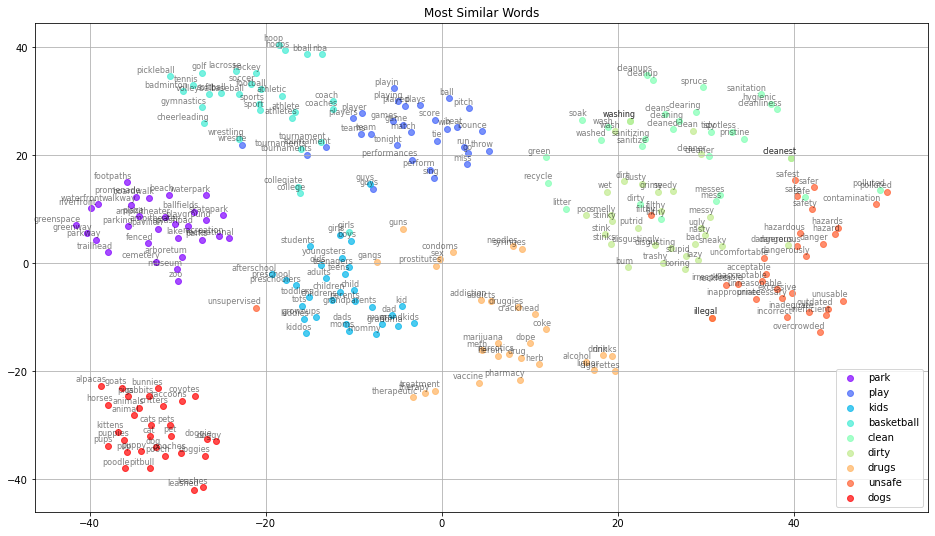

In [ ]:
def tsne_plot_similar_words(title, labels, embedding_clusters, word_clusters, a, filename=None):
    plt.figure(figsize=(16, 9))
    colors = cm.rainbow(np.linspace(0, 1, len(labels)))
    for label, embeddings, words, color in zip(labels, embedding_clusters, word_clusters, colors):
        x = embeddings[:, 0]
        y = embeddings[:, 1]
        plt.scatter(x, y, c=color, alpha=a, label=label)
        for i, word in enumerate(words):
            plt.annotate(word, alpha=0.5, xy=(x[i], y[i]), xytext=(5, 2),
                         textcoords='offset points', ha='right', va='bottom', size=8)
    plt.legend(loc=4)
    plt.title(title)
    plt.grid(True)
    if filename:
        plt.savefig(filename, format='png', dpi=150, bbox_inches='tight')
    plt.show()



tsne_plot_similar_words('Most Similar Words', keys, embeddings_en_2d, word_clusters, 0.7,
                        'similar_words.png')